# SKforecast modeling

In [ ]:
# --------------------------------------------------------------------------------------------------------
# Import necessary modules and libraries
# --------------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from meteostat import Point, Daily
from datetime import datetime
import optuna

In [11]:
# --------------------------------------------------------------------------------------------------------
# Detect and handle outliers, interpolate missing values
# --------------------------------------------------------------------------------------------------------

# Keep a copy of original target before dropping stations
original_target = final_target.copy()

# Remove stations with later start dates
exclude_stations = [f'target_{station}' for station in excluded_stations.index]
final_target = final_target.drop(columns=exclude_stations)
anomalies_stations = [f'target_{station}' for station in anomaly_stations.index]
final_target = final_target.drop(columns=anomalies_stations)

# Function to detect small outliers based on rolling median and a threshold
def detect_small_outliers_rolling(series, window_size=21, threshold=0.85):
    """
    Detect outliers using a rolling median and deviation method.

    Parameters:
    series (pd.Series): Time series data to check for outliers.
    window_size (int): Size of the rolling window for the median.
    threshold (float): Deviation threshold for detecting outliers.

    Returns:
    pd.Series: Boolean mask indicating whether an outlier is present.
    """
    rolling_median = series.rolling(window=window_size, center=False).median()
    lower_bound = rolling_median - threshold * rolling_median
    outlier_mask = series < lower_bound

    return outlier_mask

# Function to clean outliers and interpolate missing values
def clean_outliers(final_target, window_size, threshold):
    """
    Clean the data by detecting outliers, replacing them with NaNs, and interpolating the missing values.

    Parameters:
    final_target (pd.DataFrame): The target time series for each station.
    window_size (int): Size of the rolling window for outlier detection.
    threshold (float): Threshold for identifying outliers.

    Returns:
    pd.DataFrame: The cleaned and interpolated data.
    """
    outlier_mask = final_target.apply(detect_small_outliers_rolling, window_size=window_size, threshold=threshold)
    final_target[outlier_mask] = np.nan
    final_target = final_target.replace(0, np.nan)
    final_target.interpolate(method='pchip', inplace=True)
    final_target.fillna(0, inplace=True)

    assert final_target.isna().sum().sum() == 0, "NaN values found after interpolation"

    return final_target

# --------------------------------------------------------------------------------------------------------
# Function to calculate MAPE (Mean Absolute Percentage Error) excluding anomaly periods
# --------------------------------------------------------------------------------------------------------

def calculate_mape_excluding_anomalies(actual, predicted, anomalies):
    """
    Calculate MAPE, excluding anomaly periods.

    Parameters:
    actual (np.ndarray): Actual target values.
    predicted (np.ndarray): Predicted target values.
    anomalies (np.ndarray): Boolean array of anomaly flags.

    Returns:
    float: The calculated MAPE value.
    """
    valid_mask = ~anomalies
    filtered_actual = actual[valid_mask]
    filtered_predicted = predicted[valid_mask]

    if len(filtered_actual) == 0:
        return np.nan

    return mean_absolute_percentage_error(filtered_actual, filtered_predicted)

# --------------------------------------------------------------------------------------------------------
# Assign lower weights to dates during COVID lockdown periods
# --------------------------------------------------------------------------------------------------------

def custom_weights_covid(index, covid_weight=0.9):
    """
    Assign custom weights to periods affected by COVID-19 lockdowns, reducing their influence on model training.

    Parameters:
    index (pd.DatetimeIndex): Index containing dates to assign weights to.
    covid_weight (float): The weight to assign to lockdown periods (default is 0.9).

    Returns:
    np.ndarray: Array of weights for each date.
    """
    weights = np.ones(len(index))

    # Lockdown periods
    lockdown1 = (index >= '2020-03-17') & (index <= '2020-05-11')
    lockdown2 = (index >= '2020-10-30') & (index <= '2020-12-15')
    lockdown3 = (index >= '2021-04-03') & (index <= '2021-05-03')

    # Assign lower weights during lockdowns
    weights[lockdown1 | lockdown2 | lockdown3] = covid_weight

    return weights

In [12]:
# --------------------------------------------------------------------------------------------------------
# Function to perform the cleaning, multiseries forecasting, backtesting, and metric calculations for a given set of hyperparameters
# --------------------------------------------------------------------------------------------------------

def run_backtesting_multi(window_size=21, threshold=0.85, covid_weight=0.9, lags=28, n_estimators=500, max_depth=20, learning_rate=0.05, num_leaves=100):

    # Preprocess the target series to clean outliers
    cleaned_target = clean_outliers(final_target.copy(), window_size, threshold)

    # Split the data into training and testing sets based on date
    train_target_multi = cleaned_target.loc[:'2021-12-31'].copy()
    test_target_multi = cleaned_target.loc['2022-01-01':].copy()

    # Detect small outliers in the test set using rolling windows
    anomaly_flags = detect_small_outliers_rolling(test_target_multi, window_size, threshold)

    # Initialize a multi-series forecaster using LGBMRegressor with specified parameters
    forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, num_leaves=num_leaves),
                 lags               = lags,
                 transformer_series = StandardScaler(),  # Standardize the target series
                 weight_func=lambda index: custom_weights_covid(index, covid_weight)  # Apply custom weighting for COVID-19 lockdown effects
             )

    # Perform backtesting using multiseries forecaster and calculate the chosen metric (MAE)
    metric, predictions = backtesting_forecaster_multiseries(
                              forecaster         = forecaster,
                              series             = cleaned_target,
                              exog               = final_exog,
                              initial_train_size = len(train_target_multi),  # Define the size of the training set
                              steps              = 7,  # Predict 7 steps ahead (weekly forecast)
                              metric             = 'mean_absolute_error',
                              refit              = False,  # No model refitting during backtesting
                              verbose            = False,
                              show_progress      = True
                          )

    # Initialize lists and dictionaries to store results
    mape_values = []
    results_multi = {}

    # Loop through each station in the dataset and calculate predictions and MAPE
    for station in cleaned_target.columns:
        actual_values = test_target_multi[station].values
        predicted_values = predictions[station].values
        anomalies = anomaly_flags[station].values

        # Filter out anomaly values for MAPE calculation
        valid_mask = ~anomalies
        filtered_actual = actual_values[valid_mask]
        filtered_predicted = predicted_values[valid_mask]

        mape = mean_absolute_percentage_error(filtered_actual, filtered_predicted)

        # Store results for each station
        results_multi[station] = {
            'metric': metric,
            'predictions': predicted_values,
            'mape': mape
        }

        mape_values.append(mape)

    # Store MAPE values for all stations in a pandas Series
    multi_series_mape = pd.Series(
        data=mape_values,
        index=cleaned_target.columns,
        name='multi_series_mape'
    )

    # Calculate overall MAPE as the average across all stations
    overall_mape = np.mean(mape_values)
    return overall_mape, multi_series_mape, results_multi, train_target_multi, test_target_multi


In [25]:
# --------------------------------------------------------------------------------------------------------
# Train and backtest a model for each individual station
# --------------------------------------------------------------------------------------------------------

# Preprocess the target series to clean outliers
cleaned_target = clean_outliers(final_target.copy(), window_size=21, threshold=0.85)

# Split the data into training and testing sets based on date
train_target_uni = cleaned_target.loc[:'2021-12-31'].copy()
test_target_uni = cleaned_target.loc['2022-01-01':].copy()

# Detect small outliers in the test set using rolling windows
anomaly_flags = detect_small_outliers_rolling(test_target_uni, window_size=21, threshold=0.85)

# Initialize lists and dictionaries to store results for univariate models
items = []
predictions_uni = {}
mape_values_uni = []
results_uni = {}

# Loop through each station and backtest an individual model (univariate approach)
for i, item in enumerate(train_target_uni.columns):
    # Define univariate forecaster for each station using LGBMRegressor
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123, verbose=-1, learning_rate=0.05, max_depth=20, n_estimators=500, num_leaves=100),
                     lags          = 28,  # Use 28 lags for autoregression
                     transformer_y = StandardScaler(),  # Standardize the target series
                     weight_func   = custom_weights_covid  # Apply custom COVID-19 weights
                 )

    # Perform backtesting for the station and calculate the metric (MAE)
    print("Starting backtesting for station:", item)
    metric_uni, preds_uni = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = cleaned_target[item],
                        exog               = final_exog,
                        initial_train_size = len(train_target_uni),
                        steps              = 7,  # Predict 7 steps ahead
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        verbose            = False,
                        show_progress      = True
                    )
    print("Backtesting complete for station:", item)

    # Store predictions and results
    items.append(item)
    predictions_uni[item] = preds_uni

    # Calculate MAPE excluding anomalies
    anomaly_flags_uni = detect_small_outliers_rolling(test_target_uni[item], window_size=21, threshold=0.8)
    actual_values = test_target_uni[item].values
    predicted_values = preds_uni.values

    valid_mask = ~anomaly_flags_uni
    filtered_actual = actual_values[valid_mask]
    filtered_predicted = predicted_values[valid_mask]

    mape = mean_absolute_percentage_error(filtered_actual, filtered_predicted)
    mape_values_uni.append(mape)

    # Store results for each station
    results_uni[item] = {
        'metric': metric_uni,
        'predictions': predicted_values,
        'mape': mape
    }

# Store MAPE values for univariate models in a pandas Series
uni_series_mape = pd.Series(
                     data  = mape_values_uni,
                     index = items,
                     name  = 'uni_series_mape'
                 )

# Calculate overall MAPE for univariate models as the average across stations
overall_mape_uni = np.mean(mape_values_uni)
print(f"Average MAPE across all stations using individual models (excluding anomalies): {overall_mape_uni:.4f}%")


Starting backtesting for station: target_003


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_003
Starting backtesting for station: target_033


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_033
Starting backtesting for station: target_034


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_034
Starting backtesting for station: target_09U


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_09U
Starting backtesting for station: target_0CM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0CM
Starting backtesting for station: target_0GU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0GU
Starting backtesting for station: target_0JU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0JU
Starting backtesting for station: target_0S9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0S9
Starting backtesting for station: target_0TR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0TR
Starting backtesting for station: target_0WC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0WC
Starting backtesting for station: target_0Y9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0Y9
Starting backtesting for station: target_0YY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0YY
Starting backtesting for station: target_0ZP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_0ZP
Starting backtesting for station: target_11W


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_11W
Starting backtesting for station: target_12Q


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_12Q
Starting backtesting for station: target_182


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_182
Starting backtesting for station: target_18L


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_18L
Starting backtesting for station: target_193


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_193
Starting backtesting for station: target_19G


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_19G
Starting backtesting for station: target_1AA


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1AA
Starting backtesting for station: target_1EB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1EB
Starting backtesting for station: target_1EJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1EJ
Starting backtesting for station: target_1EX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1EX
Starting backtesting for station: target_1I8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1I8
Starting backtesting for station: target_1J7


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1J7
Starting backtesting for station: target_1PW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1PW
Starting backtesting for station: target_1TE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1TE
Starting backtesting for station: target_1TQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1TQ
Starting backtesting for station: target_1VL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_1VL
Starting backtesting for station: target_214


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_214
Starting backtesting for station: target_222


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_222
Starting backtesting for station: target_23N


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_23N
Starting backtesting for station: target_25G


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_25G
Starting backtesting for station: target_26J


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_26J
Starting backtesting for station: target_276


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_276
Starting backtesting for station: target_289


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_289
Starting backtesting for station: target_294


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_294
Starting backtesting for station: target_2AC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2AC
Starting backtesting for station: target_2EW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2EW
Starting backtesting for station: target_2P1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2P1
Starting backtesting for station: target_2PZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2PZ
Starting backtesting for station: target_2SG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2SG
Starting backtesting for station: target_2T1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2T1
Starting backtesting for station: target_2UV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2UV
Starting backtesting for station: target_2YA


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_2YA
Starting backtesting for station: target_30I


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_30I
Starting backtesting for station: target_30R


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_30R
Starting backtesting for station: target_34L


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_34L
Starting backtesting for station: target_357


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_357
Starting backtesting for station: target_3KU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3KU
Starting backtesting for station: target_3NQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3NQ
Starting backtesting for station: target_3NS


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3NS
Starting backtesting for station: target_3T2


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3T2
Starting backtesting for station: target_3W6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3W6
Starting backtesting for station: target_3XF


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3XF
Starting backtesting for station: target_3Y4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_3Y4
Starting backtesting for station: target_43B


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_43B
Starting backtesting for station: target_45E


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_45E
Starting backtesting for station: target_47F


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_47F
Starting backtesting for station: target_488


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_488
Starting backtesting for station: target_495


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_495
Starting backtesting for station: target_4AH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4AH
Starting backtesting for station: target_4CZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4CZ
Starting backtesting for station: target_4EG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4EG
Starting backtesting for station: target_4IM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4IM
Starting backtesting for station: target_4MO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4MO
Starting backtesting for station: target_4PO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4PO
Starting backtesting for station: target_4RW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4RW
Starting backtesting for station: target_4SH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4SH
Starting backtesting for station: target_4UY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4UY
Starting backtesting for station: target_4V8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4V8
Starting backtesting for station: target_4WI


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4WI
Starting backtesting for station: target_4YU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_4YU
Starting backtesting for station: target_52H


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_52H
Starting backtesting for station: target_56P


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_56P
Starting backtesting for station: target_56W


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_56W
Starting backtesting for station: target_59A


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_59A
Starting backtesting for station: target_5GK


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5GK
Starting backtesting for station: target_5KB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5KB
Starting backtesting for station: target_5KJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5KJ
Starting backtesting for station: target_5MR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5MR
Starting backtesting for station: target_5PK


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5PK
Starting backtesting for station: target_5S5


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5S5
Starting backtesting for station: target_5SM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5SM
Starting backtesting for station: target_5U5


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5U5
Starting backtesting for station: target_5WG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5WG
Starting backtesting for station: target_5ZC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_5ZC
Starting backtesting for station: target_651


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_651
Starting backtesting for station: target_6A9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6A9
Starting backtesting for station: target_6DU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6DU
Starting backtesting for station: target_6E0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6E0
Starting backtesting for station: target_6FB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6FB
Starting backtesting for station: target_6HE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6HE
Starting backtesting for station: target_6TL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6TL
Starting backtesting for station: target_6UW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6UW
Starting backtesting for station: target_6VM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6VM
Starting backtesting for station: target_6WR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_6WR
Starting backtesting for station: target_700


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_700
Starting backtesting for station: target_72S


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_72S
Starting backtesting for station: target_745


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_745
Starting backtesting for station: target_7EJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_7EJ
Starting backtesting for station: target_7NG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_7NG
Starting backtesting for station: target_856


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_856
Starting backtesting for station: target_87K


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_87K
Starting backtesting for station: target_8E0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_8E0
Starting backtesting for station: target_8PU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_8PU
Starting backtesting for station: target_8QR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_8QR
Starting backtesting for station: target_8WZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_8WZ
Starting backtesting for station: target_8X9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_8X9
Starting backtesting for station: target_8XN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_8XN
Starting backtesting for station: target_92P


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_92P
Starting backtesting for station: target_94K


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_94K
Starting backtesting for station: target_959


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_959
Starting backtesting for station: target_969


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_969
Starting backtesting for station: target_9IN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9IN
Starting backtesting for station: target_9IV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9IV
Starting backtesting for station: target_9LN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9LN
Starting backtesting for station: target_9MC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9MC
Starting backtesting for station: target_9P6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9P6
Starting backtesting for station: target_9RF


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9RF
Starting backtesting for station: target_9WY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_9WY
Starting backtesting for station: target_A1R


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_A1R
Starting backtesting for station: target_A8Q


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_A8Q
Starting backtesting for station: target_AGN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_AGN
Starting backtesting for station: target_AK3


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_AK3
Starting backtesting for station: target_ANI


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ANI
Starting backtesting for station: target_AOH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_AOH
Starting backtesting for station: target_AOW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_AOW
Starting backtesting for station: target_APM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_APM
Starting backtesting for station: target_APN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_APN
Starting backtesting for station: target_ARC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ARC
Starting backtesting for station: target_AZV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_AZV
Starting backtesting for station: target_B34


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B34
Starting backtesting for station: target_B3D


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B3D
Starting backtesting for station: target_B3W


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B3W
Starting backtesting for station: target_B45


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B45
Starting backtesting for station: target_B5A


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B5A
Starting backtesting for station: target_B61


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B61
Starting backtesting for station: target_B65


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B65
Starting backtesting for station: target_B8A


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B8A
Starting backtesting for station: target_B9M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_B9M
Starting backtesting for station: target_BC6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BC6
Starting backtesting for station: target_BE1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BE1
Starting backtesting for station: target_BHE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BHE
Starting backtesting for station: target_BI7


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BI7
Starting backtesting for station: target_BJ5


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BJ5
Starting backtesting for station: target_BJM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BJM
Starting backtesting for station: target_BKJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BKJ
Starting backtesting for station: target_BL1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BL1
Starting backtesting for station: target_BNR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BNR
Starting backtesting for station: target_BPW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BPW
Starting backtesting for station: target_BRP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BRP
Starting backtesting for station: target_BRZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BRZ
Starting backtesting for station: target_BUH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BUH
Starting backtesting for station: target_BUY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BUY
Starting backtesting for station: target_BZ0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BZ0
Starting backtesting for station: target_BZL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_BZL
Starting backtesting for station: target_C3A


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_C3A
Starting backtesting for station: target_C4L


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_C4L
Starting backtesting for station: target_C5E


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_C5E
Starting backtesting for station: target_CET


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CET
Starting backtesting for station: target_CJP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CJP
Starting backtesting for station: target_CM6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CM6
Starting backtesting for station: target_CQT


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CQT
Starting backtesting for station: target_CRS


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CRS
Starting backtesting for station: target_CS1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CS1
Starting backtesting for station: target_CSD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CSD
Starting backtesting for station: target_CUF


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CUF
Starting backtesting for station: target_CW1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CW1
Starting backtesting for station: target_CWQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CWQ
Starting backtesting for station: target_CYD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_CYD
Starting backtesting for station: target_D68


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_D68
Starting backtesting for station: target_DBV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_DBV
Starting backtesting for station: target_DF2


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_DF2
Starting backtesting for station: target_DMX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_DMX
Starting backtesting for station: target_DRI


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_DRI
Starting backtesting for station: target_DS2


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_DS2
Starting backtesting for station: target_DSX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_DSX
Starting backtesting for station: target_E6L


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_E6L
Starting backtesting for station: target_E9M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_E9M
Starting backtesting for station: target_EBP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EBP
Starting backtesting for station: target_EFN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EFN
Starting backtesting for station: target_EHY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EHY
Starting backtesting for station: target_EIZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EIZ
Starting backtesting for station: target_EK4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EK4
Starting backtesting for station: target_EMR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EMR
Starting backtesting for station: target_EOE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EOE
Starting backtesting for station: target_EPD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EPD
Starting backtesting for station: target_EQX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EQX
Starting backtesting for station: target_ESA


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ESA
Starting backtesting for station: target_EVR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_EVR
Starting backtesting for station: target_F30


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_F30
Starting backtesting for station: target_F77


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_F77
Starting backtesting for station: target_F7I


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_F7I
Starting backtesting for station: target_FA8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FA8
Starting backtesting for station: target_FBH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FBH
Starting backtesting for station: target_FBN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FBN
Starting backtesting for station: target_FK3


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FK3
Starting backtesting for station: target_FKG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FKG
Starting backtesting for station: target_FSR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FSR
Starting backtesting for station: target_FTX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FTX
Starting backtesting for station: target_FYB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_FYB
Starting backtesting for station: target_G10


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_G10
Starting backtesting for station: target_G1F


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_G1F
Starting backtesting for station: target_GIE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GIE
Starting backtesting for station: target_GKH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GKH
Starting backtesting for station: target_GMD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GMD
Starting backtesting for station: target_GN3


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GN3
Starting backtesting for station: target_GOJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GOJ
Starting backtesting for station: target_GTH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GTH
Starting backtesting for station: target_GUQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GUQ
Starting backtesting for station: target_GV0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_GV0
Starting backtesting for station: target_H1M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_H1M
Starting backtesting for station: target_H2L


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_H2L
Starting backtesting for station: target_H2M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_H2M
Starting backtesting for station: target_H5M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_H5M
Starting backtesting for station: target_HID


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HID
Starting backtesting for station: target_HN1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HN1
Starting backtesting for station: target_HOC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HOC
Starting backtesting for station: target_HOX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HOX
Starting backtesting for station: target_HW6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HW6
Starting backtesting for station: target_HXV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HXV
Starting backtesting for station: target_HZ1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_HZ1
Starting backtesting for station: target_I10


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I10
Starting backtesting for station: target_I1K


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I1K
Starting backtesting for station: target_I6E


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I6E
Starting backtesting for station: target_I7J


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I7J
Starting backtesting for station: target_I8D


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I8D
Starting backtesting for station: target_I8O


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I8O
Starting backtesting for station: target_I9K


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I9K
Starting backtesting for station: target_I9U


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_I9U
Starting backtesting for station: target_IAM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_IAM
Starting backtesting for station: target_ICH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ICH
Starting backtesting for station: target_IFB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_IFB
Starting backtesting for station: target_IJC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_IJC
Starting backtesting for station: target_IJR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_IJR
Starting backtesting for station: target_IOR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_IOR
Starting backtesting for station: target_J4R


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_J4R
Starting backtesting for station: target_J52


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_J52
Starting backtesting for station: target_J9C


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_J9C
Starting backtesting for station: target_J9O


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_J9O
Starting backtesting for station: target_JCN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JCN
Starting backtesting for station: target_JCW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JCW
Starting backtesting for station: target_JD3


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JD3
Starting backtesting for station: target_JFA


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JFA
Starting backtesting for station: target_JP8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JP8
Starting backtesting for station: target_JX6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JX6
Starting backtesting for station: target_JXV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_JXV
Starting backtesting for station: target_K2M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_K2M
Starting backtesting for station: target_K4X


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_K4X
Starting backtesting for station: target_K5Q


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_K5Q
Starting backtesting for station: target_K6N


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_K6N
Starting backtesting for station: target_K71


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_K71
Starting backtesting for station: target_K75


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_K75
Starting backtesting for station: target_KA0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KA0
Starting backtesting for station: target_KAX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KAX
Starting backtesting for station: target_KBV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KBV
Starting backtesting for station: target_KDO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KDO
Starting backtesting for station: target_KEC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KEC
Starting backtesting for station: target_KHT


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KHT
Starting backtesting for station: target_KN2


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KN2
Starting backtesting for station: target_KO0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KO0
Starting backtesting for station: target_KQC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KQC
Starting backtesting for station: target_KY2


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KY2
Starting backtesting for station: target_KY6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_KY6
Starting backtesting for station: target_L15


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_L15
Starting backtesting for station: target_L58


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_L58
Starting backtesting for station: target_L6F


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_L6F
Starting backtesting for station: target_LHY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_LHY
Starting backtesting for station: target_M36


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_M36
Starting backtesting for station: target_MBB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MBB
Starting backtesting for station: target_MBC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MBC
Starting backtesting for station: target_MDL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MDL
Starting backtesting for station: target_MIH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MIH
Starting backtesting for station: target_MK9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MK9
Starting backtesting for station: target_MM6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MM6
Starting backtesting for station: target_MNO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MNO
Starting backtesting for station: target_MPO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MPO
Starting backtesting for station: target_MX8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_MX8
Starting backtesting for station: target_N6I


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_N6I
Starting backtesting for station: target_N6O


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_N6O
Starting backtesting for station: target_N7J


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_N7J
Starting backtesting for station: target_NEB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NEB
Starting backtesting for station: target_NEG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NEG
Starting backtesting for station: target_NSN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NSN
Starting backtesting for station: target_NT4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NT4
Starting backtesting for station: target_NVE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NVE
Starting backtesting for station: target_NWM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NWM
Starting backtesting for station: target_NXN


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NXN
Starting backtesting for station: target_NZP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NZP
Starting backtesting for station: target_NZV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_NZV
Starting backtesting for station: target_O2O


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_O2O
Starting backtesting for station: target_O5P


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_O5P
Starting backtesting for station: target_O7B


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_O7B
Starting backtesting for station: target_OD3


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OD3
Starting backtesting for station: target_OE1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OE1
Starting backtesting for station: target_OF0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OF0
Starting backtesting for station: target_OM7


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OM7
Starting backtesting for station: target_OOY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OOY
Starting backtesting for station: target_OQD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OQD
Starting backtesting for station: target_OTS


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OTS
Starting backtesting for station: target_OUG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OUG
Starting backtesting for station: target_OYD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_OYD
Starting backtesting for station: target_P3G


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_P3G
Starting backtesting for station: target_P4J


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_P4J
Starting backtesting for station: target_P7I


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_P7I
Starting backtesting for station: target_P8U


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_P8U
Starting backtesting for station: target_PBR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PBR
Starting backtesting for station: target_PCE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PCE
Starting backtesting for station: target_PD6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PD6
Starting backtesting for station: target_PEA


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PEA
Starting backtesting for station: target_PQF


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PQF
Starting backtesting for station: target_PRZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PRZ
Starting backtesting for station: target_PUW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PUW
Starting backtesting for station: target_PWO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_PWO
Starting backtesting for station: target_Q5M


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Q5M
Starting backtesting for station: target_Q62


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Q62
Starting backtesting for station: target_Q70


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Q70
Starting backtesting for station: target_QL3


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_QL3
Starting backtesting for station: target_QQJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_QQJ
Starting backtesting for station: target_QTM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_QTM
Starting backtesting for station: target_QV8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_QV8
Starting backtesting for station: target_R2F


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_R2F
Starting backtesting for station: target_R83


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_R83
Starting backtesting for station: target_RDK


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_RDK
Starting backtesting for station: target_REW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_REW
Starting backtesting for station: target_RM4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_RM4
Starting backtesting for station: target_ROF


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ROF
Starting backtesting for station: target_RPX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_RPX
Starting backtesting for station: target_RR1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_RR1
Starting backtesting for station: target_RVB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_RVB
Starting backtesting for station: target_RYX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_RYX
Starting backtesting for station: target_S3E


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_S3E
Starting backtesting for station: target_SAD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_SAD
Starting backtesting for station: target_SH9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_SH9
Starting backtesting for station: target_SSM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_SSM
Starting backtesting for station: target_SWS


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_SWS
Starting backtesting for station: target_SYW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_SYW
Starting backtesting for station: target_SZ5


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_SZ5
Starting backtesting for station: target_T16


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_T16
Starting backtesting for station: target_T29


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_T29
Starting backtesting for station: target_T2H


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_T2H
Starting backtesting for station: target_T5V


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_T5V
Starting backtesting for station: target_T91


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_T91
Starting backtesting for station: target_TCL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TCL
Starting backtesting for station: target_TEP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TEP
Starting backtesting for station: target_TFW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TFW
Starting backtesting for station: target_TGR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TGR
Starting backtesting for station: target_TGW


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TGW
Starting backtesting for station: target_TMT


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TMT
Starting backtesting for station: target_TO8


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TO8
Starting backtesting for station: target_TPX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TPX
Starting backtesting for station: target_TVC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TVC
Starting backtesting for station: target_TXU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_TXU
Starting backtesting for station: target_UAJ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_UAJ
Starting backtesting for station: target_UC4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_UC4
Starting backtesting for station: target_UCE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_UCE
Starting backtesting for station: target_UM6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_UM6
Starting backtesting for station: target_UMC


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_UMC
Starting backtesting for station: target_V2R


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_V2R
Starting backtesting for station: target_V4D


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_V4D
Starting backtesting for station: target_V5L


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_V5L
Starting backtesting for station: target_V6N


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_V6N
Starting backtesting for station: target_V8D


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_V8D
Starting backtesting for station: target_VA1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VA1
Starting backtesting for station: target_VAU


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VAU
Starting backtesting for station: target_VBL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VBL
Starting backtesting for station: target_VEF


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VEF
Starting backtesting for station: target_VEO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VEO
Starting backtesting for station: target_VGQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VGQ
Starting backtesting for station: target_VI4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VI4
Starting backtesting for station: target_VML


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VML
Starting backtesting for station: target_VMM


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VMM
Starting backtesting for station: target_VS0


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VS0
Starting backtesting for station: target_VTD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VTD
Starting backtesting for station: target_VTE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VTE
Starting backtesting for station: target_VTP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VTP
Starting backtesting for station: target_VV4


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VV4
Starting backtesting for station: target_VVQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VVQ
Starting backtesting for station: target_VZD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_VZD
Starting backtesting for station: target_W06


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_W06
Starting backtesting for station: target_W67


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_W67
Starting backtesting for station: target_W68


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_W68
Starting backtesting for station: target_W7F


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_W7F
Starting backtesting for station: target_WDG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WDG
Starting backtesting for station: target_WDP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WDP
Starting backtesting for station: target_WGP


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WGP
Starting backtesting for station: target_WIX


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WIX
Starting backtesting for station: target_WMZ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WMZ
Starting backtesting for station: target_WNT


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WNT
Starting backtesting for station: target_WO7


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WO7
Starting backtesting for station: target_WQO


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WQO
Starting backtesting for station: target_WQR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WQR
Starting backtesting for station: target_WRR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WRR
Starting backtesting for station: target_WVV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_WVV
Starting backtesting for station: target_X2X


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_X2X
Starting backtesting for station: target_X3Q


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_X3Q
Starting backtesting for station: target_X3T


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_X3T
Starting backtesting for station: target_X6B


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_X6B
Starting backtesting for station: target_X95


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_X95
Starting backtesting for station: target_XIG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XIG
Starting backtesting for station: target_XKD


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XKD
Starting backtesting for station: target_XL2


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XL2
Starting backtesting for station: target_XM1


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XM1
Starting backtesting for station: target_XN6


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XN6
Starting backtesting for station: target_XOK


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XOK
Starting backtesting for station: target_XRB


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XRB
Starting backtesting for station: target_XTG


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XTG
Starting backtesting for station: target_XUL


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XUL
Starting backtesting for station: target_XXI


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_XXI
Starting backtesting for station: target_Y1C


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Y1C
Starting backtesting for station: target_Y5A


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Y5A
Starting backtesting for station: target_YAQ


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_YAQ
Starting backtesting for station: target_YDH


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_YDH
Starting backtesting for station: target_YJK


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_YJK
Starting backtesting for station: target_YLE


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_YLE
Starting backtesting for station: target_YTV


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_YTV
Starting backtesting for station: target_YX9


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_YX9
Starting backtesting for station: target_Z1H


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Z1H
Starting backtesting for station: target_Z2T


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Z2T
Starting backtesting for station: target_Z4A


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Z4A
Starting backtesting for station: target_Z5T


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Z5T
Starting backtesting for station: target_Z76


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_Z76
Starting backtesting for station: target_ZII


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ZII
Starting backtesting for station: target_ZIK


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ZIK
Starting backtesting for station: target_ZSR


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ZSR
Starting backtesting for station: target_ZXY


  0%|          | 0/53 [00:00<?, ?it/s]

Backtesting complete for station: target_ZXY
Average MAPE across all stations using individual models (excluding anomalies): 0.2712%


In [14]:
# --------------------------------------------------------------------------------------------------------
# Train and backtest a global multi-series model for all stations
# --------------------------------------------------------------------------------------------------------

# Perform multiseries backtesting using the run_backtesting_multi function
backtesting_results = run_backtesting_multi(window_size=21, threshold=0.85, covid_weight=0.9, lags=28, n_estimators=500, max_depth=20, learning_rate=0.05, num_leaves=100)

# Extract overall MAPE, per-station MAPE, and detailed results from the backtesting
overall_mape_multi = backtesting_results[0]
multi_series_mape = backtesting_results[1]
results_multi = backtesting_results[2]
train_target_multi = backtesting_results[3]
test_target_multi = backtesting_results[4]

print(f"Average MAPE across all stations using multiseries model (excluding anomalies): {overall_mape_multi:.4f}%")


  0%|          | 0/53 [00:00<?, ?it/s]

Average MAPE across all stations using multiseries model (excluding anomalies): 0.1929%


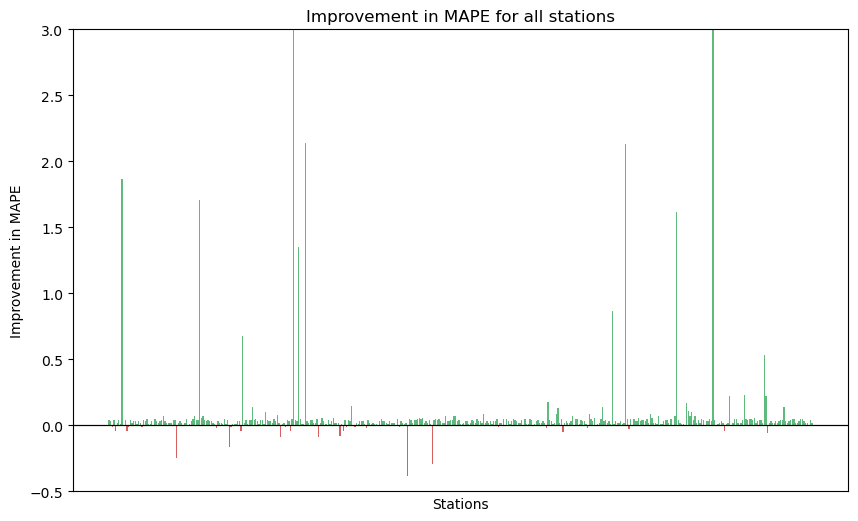

In [26]:
# --------------------------------------------------------------------------------------------------------
# Compare univariate series vs multiseries performance
# --------------------------------------------------------------------------------------------------------

# Combine MAPE results from univariate and multiseries models
multi_series_mape.columns = ['multi_series_mape']
final_results = pd.concat((uni_series_mape, multi_series_mape), axis=1)

# Calculate the improvement in MAPE for each station
final_results['improvement'] = final_results.eval('uni_series_mape - multi_series_mape')
final_results['improvement_(%)'] = 100 * final_results.eval('(uni_series_mape - multi_series_mape) / uni_series_mape')
final_results = final_results.round(2)

# Plot improvement in MAPE across stations
plt.figure(figsize=(10, 6))
plt.bar(final_results.index, final_results['improvement'], color=[('#d65f5f' if x < 0 else '#5fba7d') for x in final_results['improvement']])
plt.axhline(0, color='black', linewidth=0.8)

# Draw a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.8)

# Set the y-axis limits to between -80 and +80
plt.ylim(-0.5, 3)

# Hide the x-axis station names (ticks)
plt.xticks(ticks=[])

# Set labels and title
plt.xlabel('Stations')
plt.ylabel('Improvement in MAPE')
plt.title('Improvement in MAPE for all stations')

# Show the plot
plt.show()

In [ ]:
# --------------------------------------------------------------------------------------------------------
# Custom Hyperparameter Bayesian Search including: window, threshold, lags and covid weight
# --------------------------------------------------------------------------------------------------------

# Define the search space for hyperparameters using Optuna
def search_space(trial):
    return {
        'window_size': trial.suggest_categorical('window_size', [14, 21, 30]),  # Window sizes for the rolling outlier detector
        'threshold': trial.suggest_categorical('threshold', [0.8, 0.85, 0.9]),  # Threshold for outlier detection
        'covid_weight': trial.suggest_categorical('covid_weight', [0.5, 0.7, 0.9]),  # Weight adjustment for the COVID lockdown period
        'lags': trial.suggest_categorical('lags', [14, 28, 35]),  # Lags for autoregression
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),  # Number of LightGBM trees
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),  # LightGBM learning rate
        'num_leaves': trial.suggest_categorical('num_leaves', [50, 70, 100]),  # Max leaves in LightGBM
        'max_depth': trial.suggest_categorical('max_depth', [10, 20, 30])  # Max tree depth in LightGBM
    }

# Objective function for the Bayesian search (minimizing the MAPE metric)
def objective(trial):
    params = search_space(trial)

    # Run backtesting with the parameters suggested by the trial
    return run_backtesting_multi(
        window_size=params['window_size'],
        threshold=params['threshold'],
        covid_weight=params['covid_weight'],
        lags=params['lags'],
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves']
    )[0]  # Return MAPE as the objective to minimize

# Create an Optuna study for hyperparameter tuning
study = optuna.create_study(direction='minimize')  # Aim to minimize MAPE

# Optimize the study using the defined objective function
study.optimize(objective, n_trials=20)  # Run 20 trials for the search

# Retrieve the best set of hyperparameters and the lowest MAPE
best_params = study.best_params
best_mape = study.best_value

# Print the results of the optimization
print(f"Best MAPE: {best_mape}")
print(f"Best Parameters: {best_params}")

In [4]:
# --------------------------------------------------------------------------------------------------------
# Handle anomaly stations
# --------------------------------------------------------------------------------------------------------

# Clean and interpolate outliers from the original target data
# This function removes outliers based on a rolling window and a threshold
cleaned_original = clean_outliers(original_target.copy(), window_size=21, threshold=0.8)

# Define the end date for the dataset
end_date = pd.to_datetime('2023-01-01')

# Define a valid train-test split ratio for splitting data into training and test sets
train_test_split_ratio = 0.7

# Initialize an empty dictionary to store results for each station
results = {}

# Update anomaly station index to have the prefix 'target_' for consistent naming
anomaly_stations.index = ['target_' + station for station in anomaly_stations.index]

# Loop through each station marked as an anomaly, perform backtesting
for station, start_date_str in anomaly_stations.items():
    # Convert the start date (string format) to datetime format
    start_date = pd.to_datetime(start_date_str)

    # Calculate the total number of data points available between start and end dates
    total_data = len(cleaned_original[station].loc[start_date:end_date])

    # Calculate the size of the training and testing sets based on the split ratio
    train_size = int(total_data * train_test_split_ratio)
    test_size = total_data - train_size

    # Define training data as the first part of the dataset
    train_data = cleaned_original[station].iloc[:train_size]

    # Define testing data as the remaining part of the dataset
    test_data = cleaned_original[station].iloc[train_size:]

    # Initialize the forecaster (autoregressive model) with LightGBM regressor and standard scaling on the target variable
    forecaster = ForecasterAutoreg(
        regressor=LGBMRegressor(
            random_state=123,        # Set random seed for reproducibility
            verbose=-1,              # Disable verbosity
            learning_rate=0.05,      # Set learning rate for LightGBM
            max_depth=30,            # Set max depth for LightGBM trees
            n_estimators=500,        # Number of trees in LightGBM
            num_leaves=100           # Max number of leaves in each tree
        ),
        lags=28,                      # Use 28 time lags for autoregression
        transformer_y=StandardScaler() # Apply standard scaling to the target variable
    )

    # Perform backtesting on the forecaster with the specified parameters
    metric, preds = backtesting_forecaster(
        forecaster=forecaster,         # Forecaster object with LightGBM
        y=cleaned_original[station],   # Target variable for the current station
        exog=final_exog,               # Exogenous variables (features)
        initial_train_size=len(train_data),  # Size of the initial training data
        steps=len(test_data),                # Number of steps to forecast
        metric='mean_absolute_error',        # Evaluation metric (MAE)
        refit=False,                         # No refitting during backtesting
        verbose=False,                       # Disable verbosity
        show_progress=True                   # Show progress during backtesting
    )

    # Extract the mean absolute error (MAE) from the backtesting results
    mae = metric.at[0, 'mean_absolute_error']

    # Convert the actual and predicted values for MAPE calculation
    actual_values = test_data.values
    predicted_values = preds.values

    # Calculate Mean Absolute Percentage Error (MAPE) between actual and predicted values
    mape = mean_absolute_percentage_error(actual_values, predicted_values)

    # Store the results for this station in the results dictionary
    results[station] = {
        'start_date': start_date,      # Start date for this station
        'train_size': train_size,      # Size of the training set
        'test_size': test_size,        # Size of the testing set
        'mae': mae,                    # Mean Absolute Error
        'mape': mape                   # Mean Absolute Percentage Error
    }

    # Print the results for this station
    print(f"Station: {station}")
    print(f"Start Date: {start_date}")
    print(f"Train Size: {train_size}")
    print(f"Test Size: {test_size}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print()

# Convert the results dictionary into a DataFrame for easier inspection
anomaly_results_df = pd.DataFrame.from_dict(results, orient='index')

# Print the DataFrame containing results for all anomaly stations
print(anomaly_results_df)

  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_48S
Start Date: 2017-07-02 00:00:00
Train Size: 1406
Test Size: 603
MAE: 1069.6943
MAPE: 7.1417



  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_GW7
Start Date: 2015-11-16 00:00:00
Train Size: 1822
Test Size: 781
MAE: 3356.0005
MAPE: 17.9863



  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_N9K
Start Date: 2017-07-01 00:00:00
Train Size: 1407
Test Size: 603
MAE: 338.6606
MAPE: 2.5330



  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_OWM
Start Date: 2017-01-17 00:00:00
Train Size: 1522
Test Size: 653
MAE: 26.1318
MAPE: 0.6373



  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_RF2
Start Date: 2015-03-15 00:00:00
Train Size: 1994
Test Size: 855
MAE: 193.5442
MAPE: 0.4348



  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_V2P
Start Date: 2017-06-06 00:00:00
Train Size: 1424
Test Size: 611
MAE: 435.1819
MAPE: 2.8366



  0%|          | 0/1 [00:00<?, ?it/s]

Station: target_TV1
Start Date: 2015-01-01 00:00:00
Train Size: 2045
Test Size: 877
MAE: 2254.8033
MAPE: 150.7123

           start_date  train_size  test_size          mae        mape
target_48S 2017-07-02        1406        603  1069.694342    7.141750
target_GW7 2015-11-16        1822        781  3356.000468   17.986279
target_N9K 2017-07-01        1407        603   338.660554    2.533020
target_OWM 2017-01-17        1522        653    26.131841    0.637315
target_RF2 2015-03-15        1994        855   193.544157    0.434814
target_V2P 2017-06-06        1424        611   435.181867    2.836560
target_TV1 2015-01-01        2045        877  2254.803271  150.712284


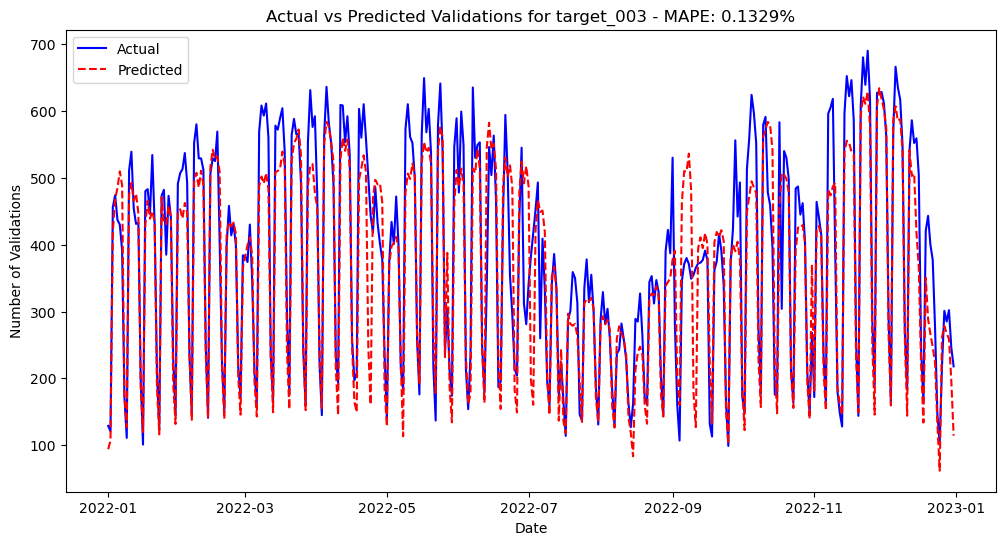

In [24]:
# --------------------------------------------------------------------------------------------------------
# # Visualize results for a sample station
# --------------------------------------------------------------------------------------------------------

sample_station = 'target_003'  # Change this to any station you want to visualize

test_target = test_target_multi # Change this to test_target_uni to visualize individual model
results = results_multi # Change this to results_uni to visualize individual model

plt.figure(figsize=(12, 6))
plt.plot(test_target.index, test_target[sample_station], label='Actual', color='blue')
plt.plot(test_target.index, results[sample_station]['predictions'], label='Predicted', color='red', linestyle='dashed')
plt.title(f"Actual vs Predicted Validations for {sample_station} - MAPE: {results[sample_station]['mape']:.4f}%")
plt.xlabel('Date')
plt.ylabel('Number of Validations')
plt.legend()
plt.show()